In [2]:
import sys
sys.path.append('../data')
sys.path.append('../data/low')
sys.path.append('../data/mid')
sys.path.append('../Librerias')

import dataset as ds
import utils
import caract as dc


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from os import listdir
from os.path import isfile, join
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

import scipy.signal as signal


sns.set_style("darkgrid")

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **archivos**

In [3]:
fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/high/"
#fpath =  "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]

In [4]:
#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)
        print(fname)

high8_090124.mat
high5_100124.mat
high10_090124.mat
high10_100124.mat
high8_100124.mat
high5_090124.mat
high2_100124.mat
high7_100124.mat
high12_090124.mat
high7_090124.mat
high9_090124.mat
high9_100124.mat
high4_090124.mat
high1_090124.mat
high1_100124.mat
high6_100124.mat
high3_090124.mat
high3_100124.mat


In [5]:
defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    print(i)
    taus.append(aux.get_tau()[1])
    print(i)

0


0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17


## **psd defectos, sin interpolación**
Sin defectos, no hay trato de información perdida

In [26]:
signal_sin_defectos = []
hilbert_sin_defectos = []

for i, df in enumerate(defectos_frames):

    aux,aux_hilbert= df.get_no_defectos()
    signal_sin_defectos.append(aux)
    hilbert_sin_defectos.append(aux_hilbert)
    sys.stdout.write(str(i) + '\r')



In [7]:
signal_sin_defectos[0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
0,0.892414,0.286351,0.035339,0.035339-0.029502j
1,0.905895,0.299832,0.033637,0.033637-0.002503j
2,0.917075,0.311011,0.031906,0.031906-0.000839j
3,0.930556,0.324492,0.030149,0.030149+0.008867j
4,0.939105,0.333041,0.028367,0.028367+0.010115j
...,...,...,...,...
599995,0.371251,-0.234812,-0.003465,-0.003465-0.005847j
599996,0.348564,-0.257500,-0.003298,-0.003298-0.004618j
599997,0.344618,-0.261446,-0.003127,-0.003127-0.011439j
599998,0.325218,-0.280845,-0.002952,-0.002952-0.009812j


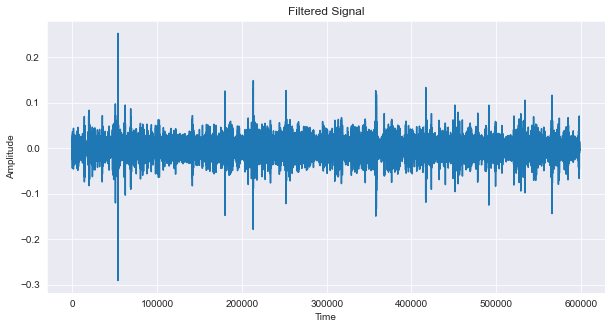

In [8]:
from scipy.signal import butter, filtfilt

# Define the cutoff frequency and the sampling frequency
cutoff_freq = 200  # Specify the cutoff frequency in Hz
sampling_freq = 1000  # Specify the sampling frequency in Hz

# Calculate the normalized cutoff frequency
normalized_cutoff_freq = cutoff_freq / (sampling_freq / 2)

# Design the filter coefficients using a Butterworth filter
order = 4  # Specify the filter order
b, a = butter(order, normalized_cutoff_freq, btype='low', analog=False)

# Apply the filter to the signal
signal_filtered = []
for elem in signal_sin_defectos:
    elem = elem.dropna()
    aux = filtfilt(b, a, elem['Filtered Signal'])
    signal_filtered.append(aux)


# Plot the filtered signal
plt.figure(figsize=(10, 5))
plt.plot(signal_filtered[0], label='Filtered signal')
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [9]:
def ffts(signal, fs=1000):
    n = len(signal)
    T = 1/fs
    yf = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d = T)
    psd = np.abs(yf)**2
    return freqs, psd

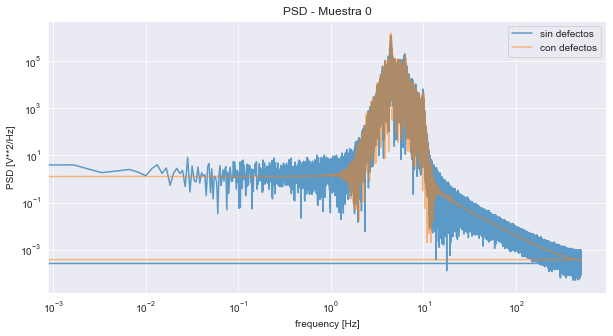

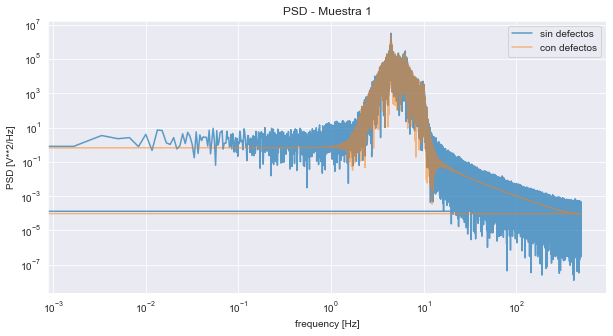

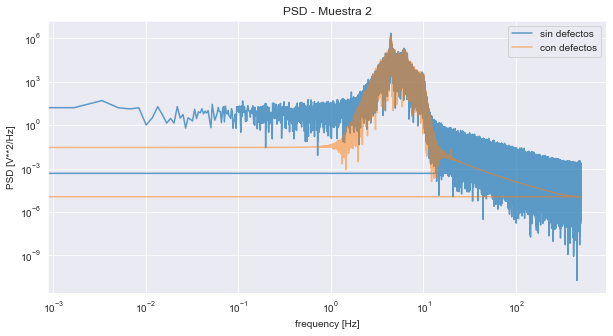

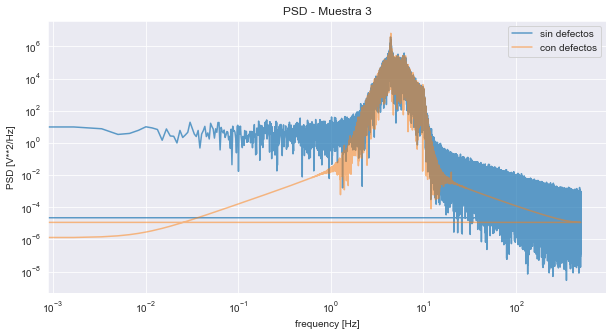

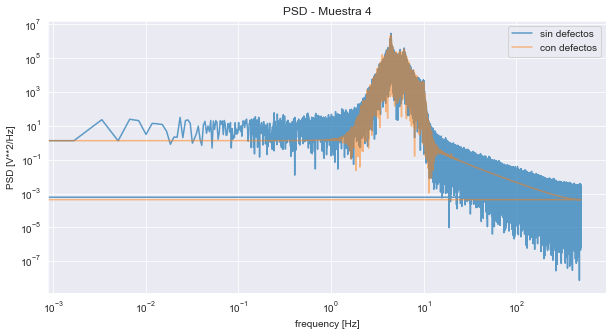

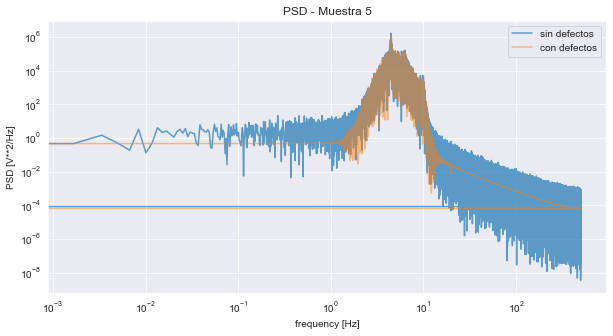

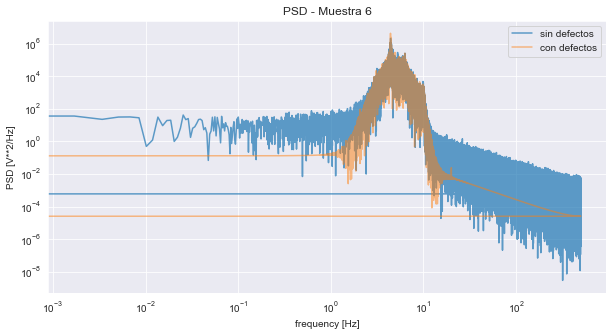

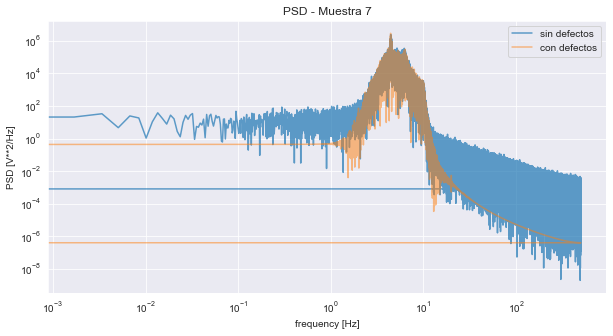

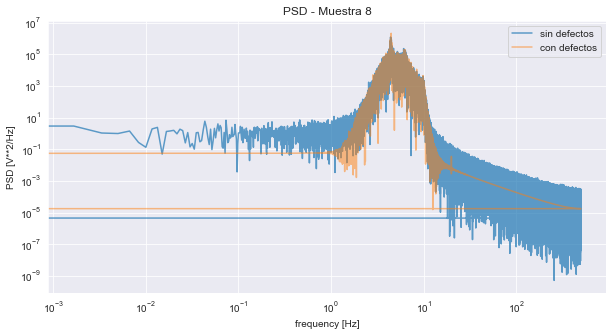

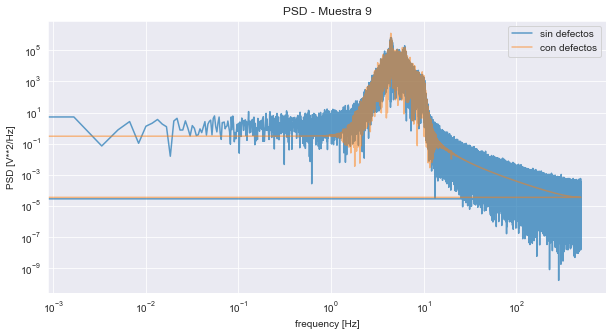

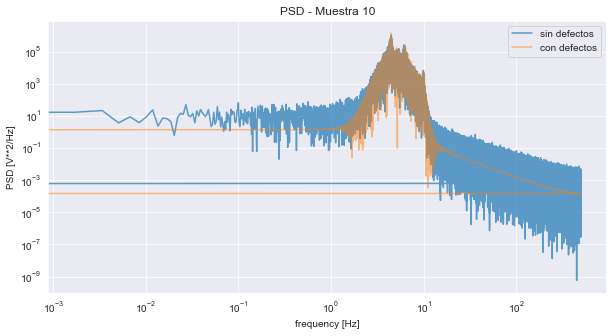

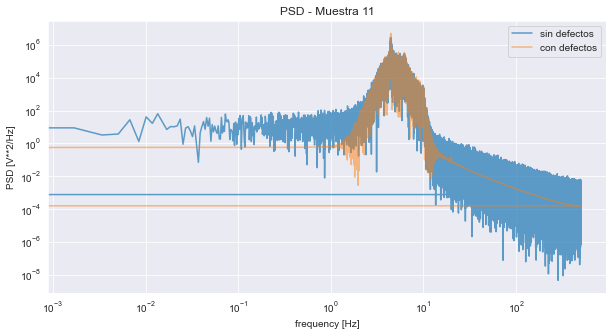

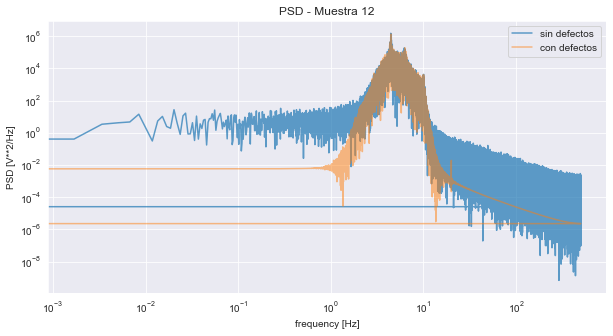

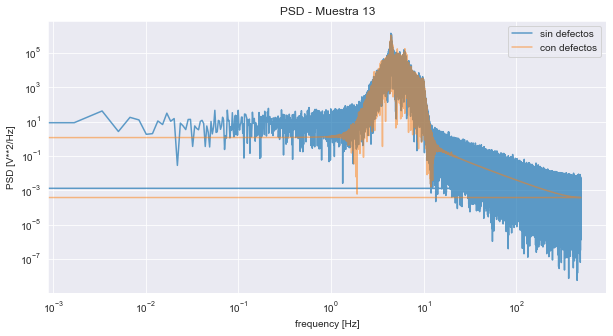

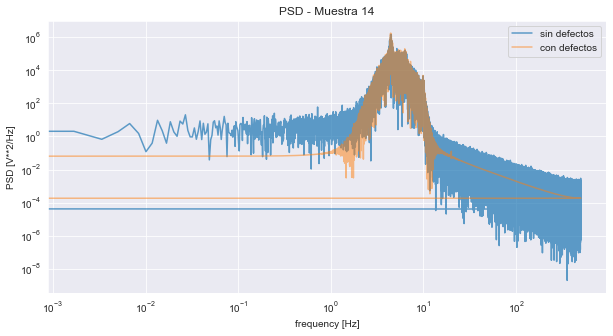

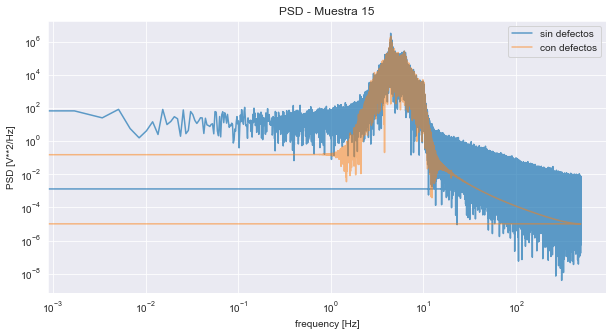

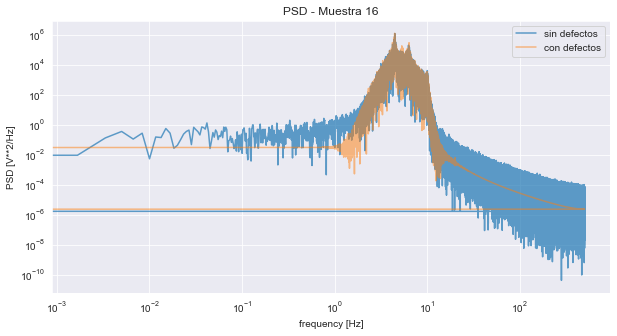

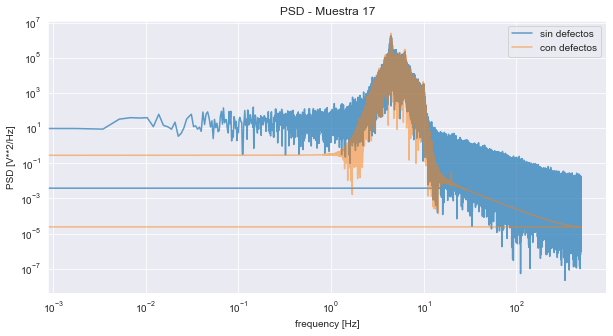

In [10]:
for i, elem in enumerate(signal_sin_defectos):
    figure = plt.figure(figsize=(10,5))
    elem = elem.dropna()
    freq1, psd1 = ffts(elem['Filtered Signal'], fs=1000)
    freq2, psd2 = ffts(frames[i]['Filtered Signal'])

    plt.loglog(freq1, psd1, label = 'sin defectos', alpha = 0.7)
    plt.loglog(freq2,psd2, label = 'con defectos', alpha = 0.5)

    plt.title(f"PSD - Muestra {i}")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend()
    plt.show()

In [11]:
hilbert_sin_defectos[0].columns

Index(['Hilbert Transform', 'Amplitude', 'Instantaneous Phase',
       'Gradient Phase'],
      dtype='object')

### **welch**

In [12]:
x_sd = []
x_defectos = []

freqs_sd = []
freqs_defectos = []

x_amp =[]
freqs_amp = [] 

for i, elem in enumerate(signal_sin_defectos):
    elem = elem.dropna()
    hilbert_sin_defectos[i] = hilbert_sin_defectos[i].dropna()
    f, pxx = signal.welch(elem['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f2, pxx2 = signal.welch(frames[i]['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f3, pxx3 = signal.welch(hilbert_sin_defectos[i]['Amplitude'], 1000, nperseg= 1024, scaling='spectrum')
    x_sd.append(pxx)
    x_defectos.append(pxx2)
    x_amp.append(pxx3)

    freqs_sd.append(f)
    freqs_defectos.append(f2)
    freqs_amp.append(f3)

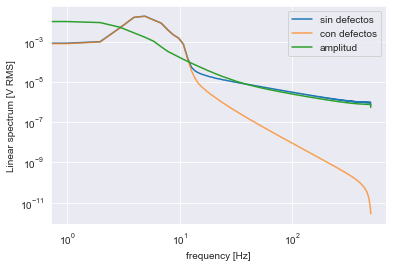

In [13]:
plt.figure()
plt.loglog(freqs_sd[14], np.sqrt(x_sd[14]), label = 'sin defectos')
plt.loglog(freqs_defectos[14], np.sqrt(x_defectos[14]), label = 'con defectos', alpha = 0.7)
plt.loglog(freqs_amp[14], np.sqrt(x_amp[14]), label = 'amplitud')
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.legend()
plt.show()

### **espectograma**

In [14]:
S_sd =[]
f_sd = []
t_sd = []

S_cd = []
f_cd = []
t_cd = []

for i, elem in enumerate(signal_sin_defectos):
    elem = elem.dropna()
    f, t, Sxx = signal.spectrogram(elem['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    f2, t2, Sxx2 = signal.spectrogram(frames[i]['Filtered Signal'], 1000, nperseg= 1024, scaling='spectrum')
    S_sd.append(Sxx)
    f_sd.append(f)
    t_sd.append(t)

    S_cd.append(Sxx2)
    f_cd.append(f2)
    t_cd.append(t2)


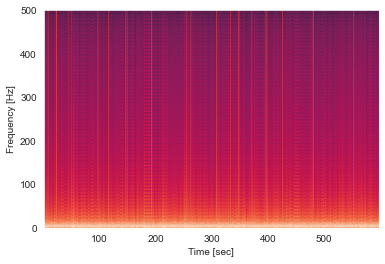

In [15]:
plt.pcolormesh(t_sd[0], f_sd[0], S_sd[0], shading= 'gouraud', norm = 'log')
#plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading='viridis', norm = 'log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

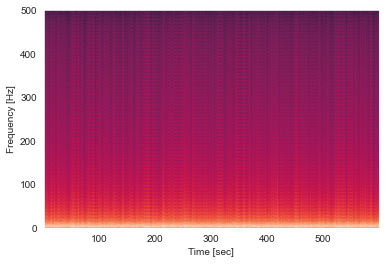

In [16]:
plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading= 'gouraud', norm = 'log')
#plt.pcolormesh(t_cd[0], f_cd[0], S_cd[0], shading='viridis', norm = 'log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## **stats**

In [17]:
all_taus = pd.concat(taus).reset_index(drop=True)
all_taus.describe()

,duration,tau,app_time
count,1305.000000,1305.000000,1287.000000
mean,25.798467,15.310345,8062.103341
std,3.584219,4.435920,11176.242976
min,5.000000,2.000000,-5.000000
25%,22.000000,12.000000,1416.000000
50%,28.000000,14.000000,4015.000000
75%,29.000000,18.000000,10070.000000
max,29.000000,26.000000,110498.000000


**para espectro y pds**
* tomar ventanas de 2 segundos, 2k muestras y a eso sacar el espectro de potencia y el espectograma y promediarlos para ver su diferencia con el espectograma y el espectro de potencia de la señal completa.

**finalizar tesis**
* entrenar algoritmo de clasificación para encontrar los defectos en otros lados
* entrenar algoritmo de predicción

**otras cosas que usar**
* caracterizar la señal bruta y la señal sin defecto. Estudiar espectro, psd, etc.
* estudiar cosas que digo que son raras, los defectos tiempo vida medio, tiempo entre defecto, si se aumenta la amplitud de la señal, se aumenta la cantidad de defectos, etc.
* agregar un shaker para tener otra señal de referencia y ver si el modelo puede encontrar los defectos en esta nueva señal y si reconoce otras cosas.

In [18]:
fig = go.Figure(data=[go.Histogram(x=all_taus['app_time'])])
fig.update_layout(title='Histogram of Difference', xaxis_title='Difference', yaxis_title='Count')
fig.show()


#### **distribuciones**

In [19]:
appearance_time = all_taus['app_time'].values
appearance_time = (appearance_time[~np.isnan(appearance_time)])


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,9.248411e-10,2740.613233,2756.093441,inf,0.037587,5.135747e-02
beta,2.099760e-09,3240.234674,3260.874951,inf,0.049217,3.784039e-03
burr,1.329213e-08,2671.169747,2691.810023,inf,0.224899,1.121586e-57
norm,4.221082e-08,4651.014736,4661.334874,inf,0.235120,4.599424e-63
chi2,5.238430e-08,2803.663993,2819.144201,inf,0.376368,2.905567e-164


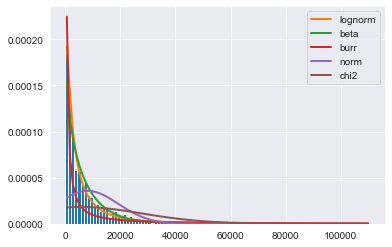

In [20]:
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()


1270


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,3.616242e-09,2508.013984,2523.454301,inf,0.058154,3.560101e-04
beta,6.058300e-09,2440.989367,2461.576455,inf,0.064547,4.819842e-05
burr,1.286705e-08,2436.941887,2457.528975,inf,0.058547,3.167157e-04
norm,8.827923e-08,2705.355350,2715.648894,inf,0.198874,1.697604e-44
lognorm,1.008288e-07,2774.059156,2789.499473,inf,0.771958,0.000000e+00


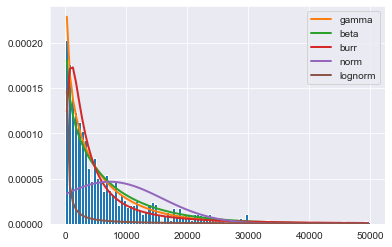

In [21]:
all_taus_2 = all_taus[all_taus['app_time'] <= 50000]
print(len(all_taus_2))

appearance_time = all_taus_2['app_time'].values
appearance_time = appearance_time[~np.isnan(appearance_time)]
f  = Fitter(appearance_time,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm",
                          "chi2"])
f.fit()
f.summary()